#### *CSC 180  Intelligent Systems (Spring 2021)*

#### *Dr. Haiquan Chen, Dept of Computer Scicence*

#### *California State University, Sacramento*
<hr>

## Project 3: Computer Vision using GPU and Transfer Learning
### **Team Members:** Quinn Roemer, Logan Hollmer

#### **Description:**
In this project we were tasked with creating CNN neural networks to classify images in ``CIFAR-10``. This dataset contains an equal number of images from each class. In order to accomplish this goal we were instructed to train custom CNN models as well as models that incorporated transfer learning from VGG16.

In [19]:
# Quinn Roemer
# SID: 301323594
# CSC 180 Intelligent Systems
# Assignment #3
# Due: April 2, 2021

# Logan Hollmer
# SID: 301559973
# CSC 180 Intelligent Systems
# Assignment #3
# Due: April 2, 2021



### Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [20]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Switch and Verify GPU

Since this notebook was created on <a href="https://colab.research.google.com/drive/1ru6-T555ccm0_hJTeuJqcubnE_RCZEo4?usp=sharing">Google Colab</a> we need to enable a GPU backend. To do this, change the following setting: *Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU*.

In [21]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

*If the above code outputs '/device:GPU:0',  you have switched to a GPU successfully and you are ready to go!*



### Mount Google Drive for File Persistence
Here I mount my personal Google Drive so we can have file persistence by saving my models in my drive.

In [22]:
from google.colab import drive, auth

#Authenticate
auth.authenticate_user()

#Mount drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Part I: Image classification without transfer learning
In this part of the assignment we will create custom CNN models to train on ``CIFAR-10``. However, before we create our models we must perform some data preprocessing.


More information about the dataset used can be found <a href="https://www.cs.toronto.edu/~kriz/cifar.html">here</a>.

In [23]:
#  Load cifar-10 data and split it to training and test
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [24]:
# Print out data shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Print out the number of samples in each
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [25]:
# Print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

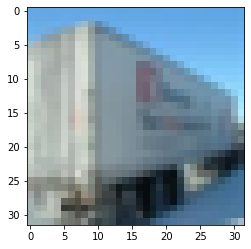

In [26]:
# Print it out as image
import matplotlib.pyplot as plt

plt.imshow(x_train[15])

In [27]:
# Convert y_train from 2D to 1D 
y_train = y_train.reshape(50000)


In [28]:
y_train.shape

# Expected output: (50000,)

(50000,)

In [29]:
# Convert y_test from 2D to 1D 
y_test = y_test.reshape(10000)


In [30]:
y_test.shape

# Expected output: (10000,)

(10000,)

In [31]:
# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [32]:
# Convert data from int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize data
x_train /= 255
x_test /= 255

### Custom CNN Models
Below you can find the 5 custom models that I defined to train on the dataset. As you can see in the comments below, some of these models were pulled from websites and the last one was completely custom. Throughout these five models you will find all the required layers below, with my custom model incorporating them all. Each model was trained with varying hyper-parameter settings. More about this can be seen below.

####  Required Layers:
- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

In [33]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization

#First three models were taken from: https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d
#Fourth model was taken from: https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8
#Fifth model is of my own design

#CNN model with 1 CNN layer
def cnn1(optimizer='adam', activation='relu'):
  cnnModel = Sequential()
  cnnModel.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=(32, 32, 3)))
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Dropout(0.2))  
  cnnModel.add(Flatten())  
  cnnModel.add(Dense(128, activation=activation))
  cnnModel.add(Dense(10, activation='softmax'))
  cnnModel.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
  return cnnModel

#CNN model with 3 CNN layers
def cnn2(optimizer='adam', activation='relu'):
  cnnModel = Sequential()
  cnnModel.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=(32, 32, 3)))
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Dropout(0.25))
  cnnModel.add(Conv2D(64, kernel_size=(3, 3), activation=activation))
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Dropout(0.25))
  cnnModel.add(Conv2D(128, kernel_size=(3, 3), activation=activation))
  cnnModel.add(Dropout(0.4))
  cnnModel.add(Flatten())
  cnnModel.add(Dense(128, activation=activation))
  cnnModel.add(Dropout(0.3))
  cnnModel.add(Dense(10, activation='softmax'))
  cnnModel.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
  return cnnModel

#CNN model with 4 CNN layers
def cnn3(optimizer='adam', activation='relu'):
  cnnModel = Sequential()
  cnnModel.add(Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=(32, 32, 3)))
  cnnModel.add(BatchNormalization())
  cnnModel.add(Conv2D(32, kernel_size=(3, 3), activation=activation))
  cnnModel.add(BatchNormalization())
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Dropout(0.25))
  cnnModel.add(Conv2D(64, kernel_size=(3, 3), activation=activation))
  cnnModel.add(BatchNormalization())
  cnnModel.add(Dropout(0.25))
  cnnModel.add(Conv2D(128, kernel_size=(3, 3), activation=activation))
  cnnModel.add(BatchNormalization())
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Dropout(0.25))
  cnnModel.add(Flatten())
  cnnModel.add(Dense(512, activation=activation))
  cnnModel.add(BatchNormalization())
  cnnModel.add(Dropout(0.5))
  cnnModel.add(Dense(128, activation=activation))
  cnnModel.add(BatchNormalization())
  cnnModel.add(Dropout(0.5))
  cnnModel.add(Dense(10, activation='softmax'))
  cnnModel.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
  return cnnModel

#CNN model with 3  CNN layers and Activation
def cnn4(optimizer='adam', activation='relu'):
  cnnModel = Sequential()
  cnnModel.add(Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3)))
  cnnModel.add(Activation(activation))
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Conv2D(32, kernel_size=(3, 3)))
  cnnModel.add(Activation(activation))
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Conv2D(64, kernel_size=(3, 3)))
  cnnModel.add(Activation(activation))
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Flatten())
  cnnModel.add(Dense(64))
  cnnModel.add(Activation(activation))
  cnnModel.add(Dropout(0.5))
  cnnModel.add(Dense(10, activation='softmax'))
  cnnModel.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
  return cnnModel

#CNN model of my own design
def cnn5(optimizer='adam', activation='relu'):
  cnnModel = Sequential()
  cnnModel.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), input_shape=(32, 32, 3)))
  cnnModel.add(Activation(activation))
  cnnModel.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2)))
  cnnModel.add(Activation(activation))
  cnnModel.add(MaxPooling2D(pool_size=(2, 2)))
  cnnModel.add(Flatten())
  cnnModel.add(Dense(64))
  cnnModel.add(Activation(activation))
  cnnModel.add(Dropout(0.5))
  cnnModel.add(Dense(10, activation='softmax'))
  cnnModel.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
  return cnnModel

In [34]:
# Print model summary
cnn1 = cnn1()
cnn1.summary()
print('\n\n')

cnn2 = cnn2()
cnn2.summary()
print('\n\n')

cnn3 = cnn3()
cnn3.summary()
print('\n\n')

cnn4 = cnn4()
cnn4.summary()
print('\n\n')

cnn5 = cnn5()
cnn5.summary()

#Add to list to easily loop over training
modelList = [cnn1, cnn2, cnn3, cnn4, cnn5]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               921728    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 923,914
Trainable params: 923,914
Non-trainable params: 0
________________________________________________

### Compiling, Earlystopping, and Fitting
Below you can see the code used to train my models. Please note, the actual model is compiled in the function defined above. As required, earlystopping and checkpoints are used to help prevent overfitting.
<br><br>
**Note:** Each model was trained 3 times to help prevent finding local optima. The first section of code just trains models with Relu activation functions and Adam optimizers.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score

#NOTE: Models have already been compiled in the previous step
i = 1

#Create monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=4, verbose=1, mode='auto')

#For each model, fit
for model in modelList:
  print('Training model: ' + str(i))
  #Train each 3 times, saving the best
  for x in range(0, 3):
    print('Training version: ' + str(x))
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/relu_adam/best_weights_' + str(i) + '.hdf5', verbose=0, save_best_only=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)

    #Predict and print report
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))

    #Recreate the model
    print('\nRecreating Default Model: ' + str(i))
    if i == 1:
      model = cnn1()
    elif i == 2:
      model = cnn2()
    elif i == 3:
      model = cnn3()
    elif i == 4:
      model = cnn4()
    else:
      model = cnn5()

  #Load best weights
  model.load_weights('/content/drive/MyDrive/CSC180_Project3/relu_adam/best_weights_' + str(i) + '.hdf5')

  #Predict and print report
  print('Best Model: ' + str(i))
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
  i += 1

Training model: 1
Training version: 0
Epoch 1/1000
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6225 - accuracy: 0.7796 - val_loss: 1.0887 - val_accuracy: 0.6614
Epoch 2/1000
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5992 - accuracy: 0.7885 - val_loss: 1.0726 - val_accuracy: 0.6565
Epoch 3/1000
1563/1563 [==============================] - 4s 3ms/step - loss: 0.5665 - accuracy: 0.8010 - val_loss: 1.1326 - val_accuracy: 0.6509
Epoch 4/1000
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5457 - accuracy: 0.8068 - val_loss: 1.1336 - val_accuracy: 0.6497
Epoch 5/1000
1563/1563 [==============================] - 4s 3ms/step - loss: 0.5227 - accuracy: 0.8137 - val_loss: 1.1607 - val_accuracy: 0.6501
Epoch 6/1000
1563/1563 [==============================] - 4s 3ms/step - loss: 0.4979 - accuracy: 0.8238 - val_loss: 1.1949 - val_accuracy: 0.6454
Epoch 00006: early stopping
F1 Score: 0.6454

Recreating Default Model: 1
Training ver

### Hyper-Parameter Tuning
In this code block, I take the 5 CNN models that I defined above and try different activation functions and optimizers. All combinations are tried except Relu/Adam as those were trained above.

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score

#Create the models, don't need to train relu adam as those we're trained in the previous steps
sigAdam1 = cnn1(optimizer='adam', activation='sigmoid')
sigAdam2 = cnn2(optimizer='adam', activation='sigmoid')
sigAdam3 = cnn3(optimizer='adam', activation='sigmoid')
sigAdam4 = cnn4(optimizer='adam', activation='sigmoid')
sigAdam5 = cnn5(optimizer='adam', activation='sigmoid')
sigAdam = [sigAdam1, sigAdam2, sigAdam3, sigAdam4, sigAdam5]

sigSGD1 = cnn1(optimizer='sgd', activation='sigmoid')
sigSGD2 = cnn2(optimizer='sgd', activation='sigmoid')
sigSGD3 = cnn3(optimizer='sgd', activation='sigmoid')
sigSGD4 = cnn4(optimizer='sgd', activation='sigmoid')
sigSGD5 = cnn5(optimizer='sgd', activation='sigmoid')
sigSGD = [sigSGD1, sigSGD2, sigSGD3, sigSGD4, sigSGD5]

tanAdam1 = cnn1(optimizer='adam', activation='tanh')
tanAdam2 = cnn2(optimizer='adam', activation='tanh')
tanAdam3 = cnn3(optimizer='adam', activation='tanh')
tanAdam4 = cnn4(optimizer='adam', activation='tanh')
tanAdam5 = cnn5(optimizer='adam', activation='tanh')
tanAdam = [tanAdam1, tanAdam2, tanAdam3, tanAdam4, tanAdam5]

tanSGD1 = cnn1(optimizer='sgd', activation='tanh')
tanSGD2 = cnn2(optimizer='sgd', activation='tanh')
tanSGD3 = cnn3(optimizer='sgd', activation='tanh')
tanSGD4 = cnn4(optimizer='sgd', activation='tanh')
tanSGD5 = cnn5(optimizer='sgd', activation='tanh')
tanSGD = [tanSGD1, tanSGD2, tanSGD3, tanSGD4, tanSGD5]

reluSGD1 = cnn1(optimizer='sgd', activation='relu')
reluSGD2 = cnn2(optimizer='sgd', activation='relu')
reluSGD3 = cnn3(optimizer='sgd', activation='relu')
reluSGD4 = cnn4(optimizer='sgd', activation='relu')
reluSGD5 = cnn5(optimizer='sgd', activation='relu')
reluSGD = (reluSGD1, reluSGD2, reluSGD3, reluSGD4, reluSGD5)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score

#Create monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=4, verbose=1, mode='auto')

#Fit sigAdam
i = 1
for model in sigAdam:
  print('Training model: ' + str(i) + ' for Sig Adam')
  #Train each 3 times, saving the best
  for x in range(0, 3):
    print('Training version: ' + str(x))
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/sig_adam/best_weights_' + str(i) + '.hdf5', verbose=0, save_best_only=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)

    #Predict and print report
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))

    #Recreate the model
    print('\nRecreating Sig Adam Model: ' + str(i))
    if i == 1:
      model = cnn1(optimizer='adam', activation='sigmoid')
    elif i == 2:
      model = cnn2(optimizer='adam', activation='sigmoid')
    elif i == 3:
      model = cnn3(optimizer='adam', activation='sigmoid')
    elif i == 4:
      model = cnn4(optimizer='adam', activation='sigmoid')
    else:
      model = cnn5(optimizer='adam', activation='sigmoid')

  #Load best weights
  model.load_weights('/content/drive/MyDrive/CSC180_Project3/sig_adam/best_weights_' + str(i) + '.hdf5')

  #Predict and print report
  print('Best Model: ' + str(i) + ' for Sig Adam')
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
  i += 1

#Fit sigSGD
i = 1
for model in sigSGD:
  print('Training model: ' + str(i) + ' for Sig SGD')
  #Train each 3 times, saving the best
  for x in range(0, 3):
    print('Training version: ' + str(x))
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/sig_sgd/best_weights_' + str(i) + '.hdf5', verbose=0, save_best_only=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)

    #Predict and print report
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))

    #Recreate the model
    print('\nRecreating Sig SGD Model: ' + str(i))
    if i == 1:
      model = cnn1(optimizer='sgd', activation='sigmoid')
    elif i == 2:
      model = cnn2(optimizer='sgd', activation='sigmoid')
    elif i == 3:
      model = cnn3(optimizer='sgd', activation='sigmoid')
    elif i == 4:
      model = cnn4(optimizer='sgd', activation='sigmoid')
    else:
      model = cnn5(optimizer='sgd', activation='sigmoid')

  #Load best weights
  model.load_weights('/content/drive/MyDrive/CSC180_Project3/sig_sgd/best_weights_' + str(i) + '.hdf5')

  #Predict and print report
  print('Best Model: ' + str(i) + ' for Sig SGD')
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
  i += 1

#Fit tanAdam
i = 1
for model in tanAdam:
  print('Training model: ' + str(i) + ' for Tanh Adam')
  #Train each 3 times, saving the best
  for x in range(0, 3):
    print('Training version: ' + str(x))
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/tan_adam/best_weights_' + str(i) + '.hdf5', verbose=0, save_best_only=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)

    #Predict and print report
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))

    #Recreate the model
    print('\nRecreating Tanh Adam Model: ' + str(i))
    if i == 1:
      model = cnn1(optimizer='adam', activation='tanh')
    elif i == 2:
      model = cnn2(optimizer='adam', activation='tanh')
    elif i == 3:
      model = cnn3(optimizer='adam', activation='tanh')
    elif i == 4:
      model = cnn4(optimizer='adam', activation='tanh')
    else:
      model = cnn5(optimizer='adam', activation='tanh')

  #Load best weights
  model.load_weights('/content/drive/MyDrive/CSC180_Project3/tan_adam/best_weights_' + str(i) + '.hdf5')

  #Predict and print report
  print('Best Model: ' + str(i) + ' for Tanh Adam')
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
  i += 1

#Fit tanSGD
i = 1
for model in tanSGD:
  print('Training model: ' + str(i) + ' for Tanh SGD')
  #Train each 3 times, saving the best
  for x in range(0, 3):
    print('Training version: ' + str(x))
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/tan_sgd/best_weights_' + str(i) + '.hdf5', verbose=0, save_best_only=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)

    #Predict and print report
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))

    #Recreate the model
    print('\nRecreating Tanh SGD Model: ' + str(i))
    if i == 1:
      model = cnn1(optimizer='sgd', activation='tanh')
    elif i == 2:
      model = cnn2(optimizer='sgd', activation='tanh')
    elif i == 3:
      model = cnn3(optimizer='sgd', activation='tanh')
    elif i == 4:
      model = cnn4(optimizer='sgd', activation='tanh')
    else:
      model = cnn5(optimizer='sgd', activation='tanh')

  #Load best weights
  model.load_weights('/content/drive/MyDrive/CSC180_Project3/tan_sgd/best_weights_' + str(i) + '.hdf5')

  #Predict and print report
  print('Best Model: ' + str(i) + ' for Tanh SGD')
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
  i += 1

#Fit relu sgd
i = 1
for model in reluSGD:
  print('Training model: ' + str(i) + ' for Relu SGD')
  #Train each 3 times, saving the best
  for x in range(0, 3):
    print('Training version: ' + str(x))
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/relu_sgd/best_weights_' + str(i) + '.hdf5', verbose=0, save_best_only=True)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=1000)

    #Predict and print report
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))

    #Recreate the model
    print('\nRecreating Relu SGD Model: ' + str(i))
    if i == 1:
      model = cnn1(optimizer='sgd', activation='relu')
    elif i == 2:
      model = cnn2(optimizer='sgd', activation='relu')
    elif i == 3:
      model = cnn3(optimizer='sgd', activation='relu')
    elif i == 4:
      model = cnn4(optimizer='sgd', activation='relu')
    else:
      model = cnn5(optimizer='sgd', activation='relu')

  #Load best weights
  model.load_weights('/content/drive/MyDrive/CSC180_Project3/relu_sgd/best_weights_' + str(i) + '.hdf5')

  #Predict and print report
  print('Best Model: ' + str(i) + ' for Relu SGD')
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  print('F1 Score: ' + str(f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
  i += 1

#Training complete!
print('Training finished...')

Streaming output truncated to the last 5000 lines.
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3241 - accuracy: 0.1004 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/1000
1563/1563 [==============================] - 6s 4ms/step - loss: 2.3030 - accuracy: 0.1019 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 3/1000
1563/1563 [==============================] - 6s 4ms/step - loss: 2.3031 - accuracy: 0.1005 - val_loss: 2.3019 - val_accuracy: 0.1000
Epoch 4/1000
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1003 - accuracy: 0.2130 - val_loss: 1.7435 - val_accuracy: 0.3788
Epoch 5/1000
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7613 - accuracy: 0.3658 - val_loss: 1.5900 - val_accuracy: 0.4307
Epoch 6/1000
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6367 - accuracy: 0.4077 - val_loss: 1.5085 - val_accuracy: 0.4541
Epoch 7/1000
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5544 -

### Training Results
Below you will find the code I used to print out my results. The best model of each type is shown with their CNN type (the function used to create the model) listed first. You will find each models scores for precision, recall, F1 score, and their classification report. In addition, I printed out the confusion matrix for each model.

Best Sigmoid Adam Model
CNN Type: 3


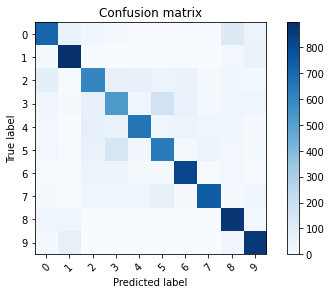

Model Precision: 0.7347
Model Recall: 0.7347
Model F1 Score: 0.7347

Model Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1000
           1       0.81      0.90      0.85      1000
           2       0.66      0.60      0.63      1000
           3       0.57      0.53      0.55      1000
           4       0.77      0.66      0.71      1000
           5       0.64      0.64      0.64      1000
           6       0.79      0.82      0.81      1000
           7       0.85      0.74      0.79      1000
           8       0.73      0.87      0.79      1000
           9       0.77      0.87      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000


Best Sigmoid SGD Model
CNN Type: 1


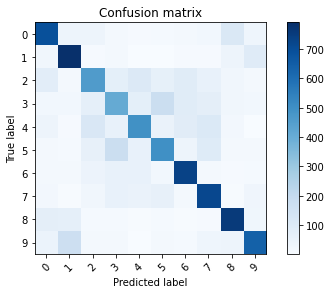

Model Precision: 0.6206
Model Recall: 0.6206
Model F1 Score: 0.6206

Model Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      1000
           1       0.69      0.79      0.74      1000
           2       0.53      0.46      0.49      1000
           3       0.46      0.41      0.43      1000
           4       0.57      0.50      0.53      1000
           5       0.54      0.50      0.52      1000
           6       0.66      0.73      0.70      1000
           7       0.62      0.72      0.66      1000
           8       0.72      0.76      0.74      1000
           9       0.71      0.64      0.67      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000


Best Tanh Adam Model
CNN Type: 4


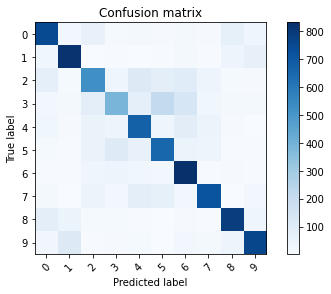

Model Precision: 0.6904
Model Recall: 0.6904
Model F1 Score: 0.6904

Model Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1000
           1       0.78      0.82      0.80      1000
           2       0.60      0.53      0.56      1000
           3       0.57      0.39      0.46      1000
           4       0.63      0.68      0.65      1000
           5       0.59      0.66      0.62      1000
           6       0.65      0.83      0.73      1000
           7       0.78      0.72      0.75      1000
           8       0.79      0.79      0.79      1000
           9       0.79      0.76      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000


Best Tanh SGD Model
CNN Type: 3


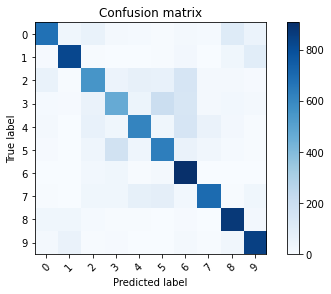

Model Precision: 0.7082
Model Recall: 0.7082
Model F1 Score: 0.7082

Model Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.73      1000
           1       0.85      0.82      0.84      1000
           2       0.64      0.55      0.59      1000
           3       0.57      0.47      0.51      1000
           4       0.70      0.61      0.65      1000
           5       0.60      0.63      0.61      1000
           6       0.60      0.91      0.72      1000
           7       0.82      0.70      0.75      1000
           8       0.77      0.87      0.82      1000
           9       0.78      0.85      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000


Best Relu Adam Model
CNN Type: 3


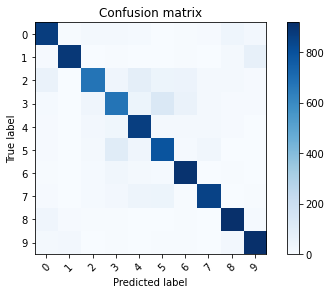

Model Precision: 0.8349
Model Recall: 0.8349
Model F1 Score: 0.8349000000000001

Model Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1000
           1       0.96      0.89      0.92      1000
           2       0.84      0.68      0.75      1000
           3       0.72      0.67      0.70      1000
           4       0.77      0.86      0.82      1000
           5       0.74      0.79      0.77      1000
           6       0.84      0.91      0.87      1000
           7       0.90      0.85      0.87      1000
           8       0.88      0.92      0.90      1000
           9       0.87      0.91      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000


Best Relu SGD Model
CNN Type: 2


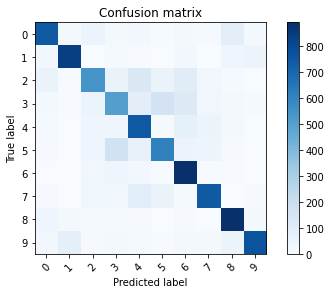

Model Precision: 0.7309
Model Recall: 0.7309
Model F1 Score: 0.7309000000000001

Model Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1000
           1       0.87      0.84      0.85      1000
           2       0.67      0.55      0.60      1000
           3       0.56      0.51      0.53      1000
           4       0.62      0.75      0.68      1000
           5       0.67      0.61      0.64      1000
           6       0.68      0.89      0.77      1000
           7       0.80      0.75      0.77      1000
           8       0.79      0.89      0.84      1000
           9       0.88      0.77      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



In [35]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
import os

%matplotlib inline

path = '/content/drive/MyDrive/CSC180_Project3/'

#Prints the confusion matrix and scores of a passed model
def printModelReport(model):
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)

  #Show confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=1), pred)
  plot_confusion_matrix(cm, list(range(10)))

  #Show model scores
  print('Model Precision: ' + str(metrics.precision_score(np.argmax(y_test, axis=1), pred, average='micro')))
  print('Model Recall: ' + str(metrics.recall_score(np.argmax(y_test, axis=1), pred, average='micro')))
  print('Model F1 Score: ' + str(metrics.f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
  print('\nModel Classification Report:\n' + str(metrics.classification_report(np.argmax(y_test, axis=1), pred)))

#Finds the best model in a given folder
def findBestModel(folderPath):
  i = 1
  maxF1 = 0
  modelNumber = 0

  for entry in os.listdir(folderPath):
    model = tf.keras.models.load_model(folderPath + entry)
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    f1Score = metrics.f1_score(np.argmax(y_test, axis=1), pred, average='micro')

    #If the f1 score is higher than saved max save the index
    if (f1Score > maxF1):
      maxF1 = f1Score
      modelNumber = i

    i += 1  
  
  #Print the report on the best model
  print('CNN Type: ' + str(modelNumber))
  model = tf.keras.models.load_model(folderPath + 'best_weights_' + str(modelNumber) + '.hdf5')
  printModelReport(model)  


#Print the best models of each type
print('Best Sigmoid Adam Model')
print('=======================')
findBestModel(path + 'sig_adam/')

print('\nBest Sigmoid SGD Model')
print('======================')
findBestModel(path + 'sig_sgd/')

print('\nBest Tanh Adam Model')
print('====================')
findBestModel(path + 'tan_adam/')

print('\nBest Tanh SGD Model')
print('===================')
findBestModel(path + 'tan_sgd/')

print('\nBest Relu Adam Model')
print('====================')
findBestModel(path + 'relu_adam/')

print('\nBest Relu SGD Model')
print('===================')
findBestModel(path + 'relu_sgd/')

### 3-5 Images with Predicted and True Labels
Using the best custom model produced (Relu/Adam of type 3) I choose 5 random images from my test set and print out the predicted label along with its actual label.

In [192]:
import random

#Best model in testing is Relu Adam CNN Type 3, we will use that
model = tf.keras.models.load_model('/content/drive/MyDrive/CSC180_Project3/relu_adam/best_weights_3.hdf5')
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

#Get a random 5 images to show
randList = random.sample(range(0, x_test.shape[0]), 5)

In [198]:
#Class names
className = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Predicted: Automobile
True: Automobile


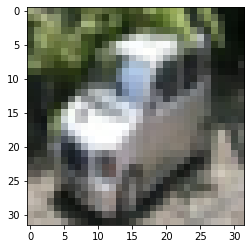

In [199]:
#Show the first image
print('Predicted: ' + className[pred[randList[0]]])
print('True: ' + className[np.argmax(y_test[randList[0]])])
plt.imshow(x_test[randList[0]])

Predicted: Horse
True: Horse


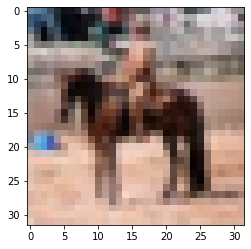

In [200]:
#Show the second image
print('Predicted: ' + className[pred[randList[1]]])
print('True: ' + className[np.argmax(y_test[randList[1]])])
plt.imshow(x_test[randList[1]])

Predicted: Automobile
True: Automobile


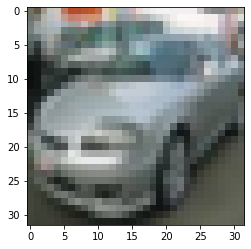

In [201]:
#Show the third image
print('Predicted: ' + className[pred[randList[2]]])
print('True: ' + className[np.argmax(y_test[randList[2]])])
plt.imshow(x_test[randList[2]])

Predicted: Dog
True: Dog


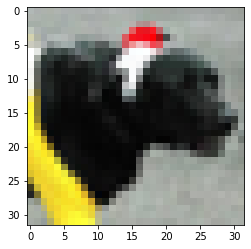

In [202]:
#Show the fourth image
print('Predicted: ' + className[pred[randList[3]]])
print('True: ' + className[np.argmax(y_test[randList[3]])])
plt.imshow(x_test[randList[3]])

Predicted: Airplane
True: Airplane


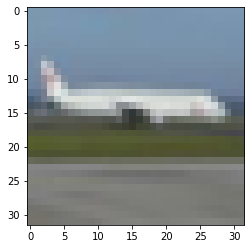

In [203]:
#Show the fifth image
print('Predicted: ' + className[pred[randList[4]]])
print('True: ' + className[np.argmax(y_test[randList[4]])])
plt.imshow(x_test[randList[4]])



### Part II:   CNN model with Transfer Learning
In this section of the report I will use transfer learning on VGG16 (required), ResNet50, and DenseNet201. To do this I will import each model, freeze their layers, and add some fully connected layers on top fit to my problem.

In [37]:
# We load data again. The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Print number of samples
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Using VGG16 for Transfer Learning
VGG16 supports down to 48x48 images as input. However, the resolution of our images is 32x32 which is too low. Thus, we need to increase the resolution (upsampling). We will accomplish this with ``skimage.transform.resize()`` which is provided by the <a href="https://scikit-image.org/">scikit-image library</a>. Note, this function normalizes our data so we have no need to do this ourselves.<br>

More information about VGG16 can be found <a href="https://neurohive.io/en/popular-networks/vgg16/">here</a>.


In [7]:
from skimage import transform

#We will a skimage function to resize the images
#Note: This function automatically normalizes the data... no need to apply after conversion
new_x_train = []

for img in x_train:
  new_x_train.append(transform.resize(img, (64, 64)))

#Convert list to numpy
new_x_train = np.array(new_x_train)

print('Old Shape: ' + str(x_train.shape))  
print('New Shape: ' + str(new_x_train.shape)) 
  
# This process may take about a few minutes...

Old Shape: (50000, 32, 32, 3)
New Shape: (50000, 64, 64, 3)


In [8]:
#We will a tensorflow function to resize the images
new_x_test = []

for img in x_test:
  new_x_test.append(transform.resize(img, (64, 64)))

#Convert list to numpy
new_x_test = np.array(new_x_test)

print('Old Shape: ' + str(x_test.shape))  
print('New Shape: ' + str(new_x_test.shape))   
  
# This process may take about a few minutes...

Old Shape: (10000, 32, 32, 3)
New Shape: (10000, 64, 64, 3)


### Data Preprocessing
Below we convert ``y_train`` and ``y_test`` from 2D to 1D by reshaping it. After this we apply One Hot Encoding (OHE) to both.

In [39]:
#Convert y_train and y_test to 1d using reshape
print('Before y_train reshape: ' + str(y_train.shape))
print('Before y_test reshape: ' + str(y_test.shape))

new_y_train = y_train.reshape(y_train.shape[0])
new_y_test = y_test.reshape(y_test.shape[0])

print('After y_train reshape: ' + str(new_y_train.shape))
print('After y_test reshape: ' + str(new_y_test.shape))

#Apply 1hot encoding
new_y_train = tf.keras.utils.to_categorical(new_y_train, num_classes)
new_y_test = tf.keras.utils.to_categorical(new_y_test, num_classes)

Before y_train reshape: (50000, 1)
Before y_test reshape: (10000, 1)
After y_train reshape: (50000,)
After y_test reshape: (10000,)


In [40]:
#Double check shape
print(new_y_train.shape)
print(new_y_test.shape)

#Expected output:  (50000, 10)
#Expected output:  (10000, 10)

(50000, 10)
(10000, 10)


### Loading VGG16
Below we load VGG16 (included in Keras) into a new model. Excluding the top layers.


In [45]:
from tensorflow.keras.applications.vgg16 import VGG16

#First hidden layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model = Sequential()
  
#Write your code here
for layer in vgg_model.layers:
  model.add(layer)

#Print out the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

### Freeze Weights
Below I freeze (make non-trainable) the weights in the transferred layers.

In [46]:
#Freeze weights on all layers
for layer in model.layers:
  layer.trainable = False

###  Add New Dense Layers
Below I add new top layers conformed to my data. I decided to use the Relu activation function on the layers before my ouput layer.

In [47]:
model.add(Flatten())

#Add some "Dense" layers here, including output layer
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

#Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

### Compile and Fit VGG16
After creating my model based off VGG16 I train it below. As required, earlystopping and checkpointing is used to help prevent overfitting. 

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score

#Define callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/vgg16/best_weights.hdf5', verbose=0, save_best_only=True)

#Compile
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

#Fit
print('Training VGG16')
model.fit(new_x_train, new_y_train, validation_data=(new_x_test, new_y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=100)

#Print F1 score of best
model.load_weights('/content/drive/MyDrive/CSC180_Project3/vgg16/best_weights.hdf5')
pred = model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
print('F1 Score: ' + str(metrics.f1_score(np.argmax(new_y_test, axis=1), pred, average='micro')))

#Since we use a GPU, the training time for each epoch for the transferred model is about 60 seconds.  

Training VGG16
Epoch 1/100
1563/1563 [==============================] - 14s 8ms/step - loss: 1.3099 - accuracy: 0.5384 - val_loss: 0.9525 - val_accuracy: 0.6684
Epoch 2/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9094 - accuracy: 0.6801 - val_loss: 0.9479 - val_accuracy: 0.6754
Epoch 3/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8101 - accuracy: 0.7141 - val_loss: 0.8934 - val_accuracy: 0.6889
Epoch 4/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7300 - accuracy: 0.7419 - val_loss: 0.8871 - val_accuracy: 0.6971
Epoch 5/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6629 - accuracy: 0.7675 - val_loss: 0.8840 - val_accuracy: 0.7002
Epoch 6/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5911 - accuracy: 0.7922 - val_loss: 0.9032 - val_accuracy: 0.7003
Epoch 7/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5306 - accuracy: 0.8116 - val

### Additional Transfer Learning
As an experiment, I also performed transfer learning on DenseNet201 and ResNet50. Two other popular image classification models. Also, I decided to retrain VGG16 with a new upsampling layer to scale the images to 224x224. This is the resolution that VGG16 used when training on ImageNet. Please note, this was accomplished by adding an Upsampling2D input layer on the original 32x32 images (not the 64x64). Below you can find the code I used to create my models as well as the code used to train each model.

In [171]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.vgg16 import VGG16

def getResNetModel():
  res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

  #Freeze layers
  for layer in res_model.layers:
    layer.trainable = False

  #Add more top layers
  newOut = res_model.output
  newOut = GlobalAveragePooling2D()(newOut)
  newOut = Dense(1024, activation='relu')(newOut)
  newOut = Dropout(0.25)(newOut)
  newOut = Dense(512, activation='relu')(newOut)
  newOut = Dense(128, activation='relu')(newOut)
  newOut = Dropout(0.25)(newOut)
  newOut = Dense(10, activation='softmax')(newOut)

  #Create model and return it
  model = Model(inputs=res_model.input, outputs=newOut)
  return model

def getDenseNetModel():
  dense_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

  #Freeze layers
  for layer in dense_model.layers:
    layer.trainable = False

  #Add more top layers
  newOut = dense_model.output
  newOut = GlobalAveragePooling2D()(newOut)
  newOut = Dense(1024, activation='relu')(newOut)
  newOut = Dropout(0.25)(newOut)
  newOut = Dense(512, activation='relu')(newOut)
  newOut = Dense(128, activation='relu')(newOut)
  newOut = Dropout(0.25)(newOut)
  newOut = Dense(10, activation='softmax')(newOut)

  #Create model and return it
  model = Model(inputs=dense_model.input, outputs=newOut)  
  return model

def getVGG16Upscaled():
  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  #Freeze layers
  for layer in vgg_model.layers:
    layer.trainable = False

  #Add an upsampling layer and some others...
  newOut = vgg_model.output
  newOut = GlobalAveragePooling2D()(newOut)
  newOut = Dense(1024, activation='relu')(newOut)
  newOut = Dropout(0.25)(newOut)
  newOut = Dense(512, activation='relu')(newOut)
  newOut = Dense(128, activation='relu')(newOut)
  newOut = Dropout(0.25)(newOut)
  newOut = Dense(10, activation='softmax')(newOut)

  model = Model(inputs=vgg_model.input, outputs=newOut)

  #Create model with upsampling
  newModel = Sequential()
  newModel.add(UpSampling2D(input_shape=(32, 32, 3), size=(7, 7)))

  for layer in model.layers:
    newModel.add(layer)

  return newModel

### Training DenseNet201
Below I train my model that incorporated transfer learning using DenseNet201.

In [174]:
#Define callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/denseNet/best_weights.hdf5', verbose=0, save_best_only=True)

#Compile
model = getDenseNetModel()
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

#Fit
print('Training DenseNet210')
model.fit(new_x_train, new_y_train, validation_data=(new_x_test, new_y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=100)

#Print F1 score of best
model.load_weights('/content/drive/MyDrive/CSC180_Project3/denseNet/best_weights.hdf5')
pred = model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
print('F1 Score: ' + str(metrics.f1_score(np.argmax(new_y_test, axis=1), pred, average='micro')))

Training DenseNet210
Epoch 1/100
1563/1563 [==============================] - 49s 25ms/step - loss: 1.1223 - accuracy: 0.6164 - val_loss: 0.8652 - val_accuracy: 0.6978
Epoch 2/100
1563/1563 [==============================] - 38s 24ms/step - loss: 0.7390 - accuracy: 0.7404 - val_loss: 0.8276 - val_accuracy: 0.7283
Epoch 3/100
1563/1563 [==============================] - 38s 24ms/step - loss: 0.6171 - accuracy: 0.7826 - val_loss: 0.8211 - val_accuracy: 0.7185
Epoch 4/100
1563/1563 [==============================] - 38s 24ms/step - loss: 0.5073 - accuracy: 0.8183 - val_loss: 0.8327 - val_accuracy: 0.7383
Epoch 5/100
1563/1563 [==============================] - 38s 24ms/step - loss: 0.4138 - accuracy: 0.8538 - val_loss: 0.8363 - val_accuracy: 0.7406
Epoch 6/100
1563/1563 [==============================] - 38s 24ms/step - loss: 0.3192 - accuracy: 0.8857 - val_loss: 0.9718 - val_accuracy: 0.7299
Epoch 7/100
1563/1563 [==============================] - 38s 24ms/step - loss: 0.2518 - accuracy:

### Training ResNet50
Below I train my model that incorporated transfer learning using ResNet50.

In [175]:
#Define callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/resnet50/best_weights.hdf5', verbose=0, save_best_only=True)

#Compile
model = getResNetModel()
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

#Fit
print('Training ResNet50')
model.fit(new_x_train, new_y_train, validation_data=(new_x_test, new_y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=100)

#Print F1 score of best
model.load_weights('/content/drive/MyDrive/CSC180_Project3/resnet50/best_weights.hdf5')
pred = model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
print('F1 Score: ' + str(metrics.f1_score(np.argmax(new_y_test, axis=1), pred, average='micro')))

Training ResNet50
Epoch 1/100
1563/1563 [==============================] - 21s 12ms/step - loss: 2.0958 - accuracy: 0.2056 - val_loss: 1.8779 - val_accuracy: 0.2988
Epoch 2/100
1563/1563 [==============================] - 18s 11ms/step - loss: 1.8480 - accuracy: 0.3137 - val_loss: 1.7731 - val_accuracy: 0.3456
Epoch 3/100
1563/1563 [==============================] - 18s 12ms/step - loss: 1.7779 - accuracy: 0.3442 - val_loss: 1.7227 - val_accuracy: 0.3637
Epoch 4/100
1563/1563 [==============================] - 18s 11ms/step - loss: 1.7458 - accuracy: 0.3587 - val_loss: 1.7228 - val_accuracy: 0.3642
Epoch 5/100
1563/1563 [==============================] - 18s 11ms/step - loss: 1.7237 - accuracy: 0.3706 - val_loss: 1.6750 - val_accuracy: 0.3882
Epoch 6/100
1563/1563 [==============================] - 18s 11ms/step - loss: 1.6970 - accuracy: 0.3817 - val_loss: 1.6833 - val_accuracy: 0.3896
Epoch 7/100
1563/1563 [==============================] - 18s 11ms/step - loss: 1.6861 - accuracy: 0.

### Training VGG16 with Upsampling
Below I train my model that incorporated transfer learning using VGG16 with an Upsampling layer. Note, I reset my data before training so I can train on 32x32 images upscaled using the Upsampling2D layer.

In [176]:
#Reset data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#Define callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=4, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Project3/vgg16withUp/best_weights.hdf5', verbose=0, save_best_only=True)

#Compile
model = getVGG16Upscaled()
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

#Fit
print('Training VGG16 with Upsampling')
model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=1, epochs=100)

#Print F1 score of best
model.load_weights('/content/drive/MyDrive/CSC180_Project3/vgg16withUp/best_weights.hdf5')
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
print('F1 Score: ' + str(metrics.f1_score(np.argmax(y_test, axis=1), pred, average='micro')))

Training VGG16 with Upsampling
Epoch 1/100
1563/1563 [==============================] - 73s 45ms/step - loss: 1.4727 - accuracy: 0.4904 - val_loss: 0.9888 - val_accuracy: 0.6578
Epoch 2/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.9036 - accuracy: 0.6807 - val_loss: 0.9528 - val_accuracy: 0.6639
Epoch 3/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.7819 - accuracy: 0.7264 - val_loss: 0.8459 - val_accuracy: 0.7063
Epoch 4/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.7083 - accuracy: 0.7530 - val_loss: 0.8057 - val_accuracy: 0.7177
Epoch 5/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.6293 - accuracy: 0.7804 - val_loss: 0.8440 - val_accuracy: 0.7081
Epoch 6/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5886 - accuracy: 0.7988 - val_loss: 0.8133 - val_accuracy: 0.7274
Epoch 7/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5584 -

### Training Results
Below you will find the code I used to print out my results for my models trained using transfer learning. You will find each models scores for precision, recall, F1 score, and their classification report. In addition, I printed out the confusion matrix for each model.

In [177]:
vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/CSC180_Project3/vgg16/best_weights.hdf5')
vgg16Up_model = tf.keras.models.load_model('/content/drive/MyDrive/CSC180_Project3/vgg16withUp/best_weights.hdf5')
dense_model = tf.keras.models.load_model('/content/drive/MyDrive/CSC180_Project3/denseNet/best_weights.hdf5')
res_model = tf.keras.models.load_model('/content/drive/MyDrive/CSC180_Project3/resnet50/best_weights.hdf5')

Transfer Learning: VGG16 Model


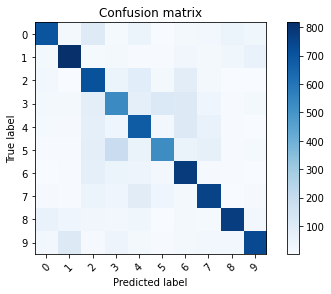

Model Precision: 0.7002
Model Recall: 0.7002
Model F1 Score: 0.7002

Model Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      1000
           1       0.80      0.82      0.81      1000
           2       0.59      0.71      0.64      1000
           3       0.54      0.53      0.54      1000
           4       0.60      0.68      0.64      1000
           5       0.69      0.52      0.60      1000
           6       0.64      0.78      0.70      1000
           7       0.74      0.76      0.75      1000
           8       0.85      0.77      0.81      1000
           9       0.83      0.73      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000


Transfer Learning: VGG16 Model with Upsampling


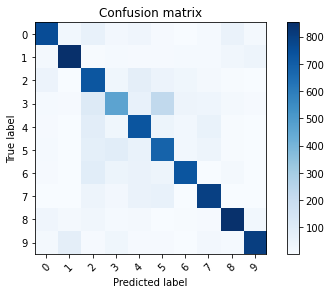

Model Precision: 0.7389
Model Recall: 0.7389
Model F1 Score: 0.7389

Model Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1000
           1       0.85      0.85      0.85      1000
           2       0.58      0.73      0.65      1000
           3       0.61      0.47      0.53      1000
           4       0.65      0.73      0.69      1000
           5       0.60      0.68      0.64      1000
           6       0.82      0.73      0.77      1000
           7       0.79      0.80      0.79      1000
           8       0.85      0.85      0.85      1000
           9       0.89      0.80      0.84      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000


Transfer Learning: DenseNet201 Model


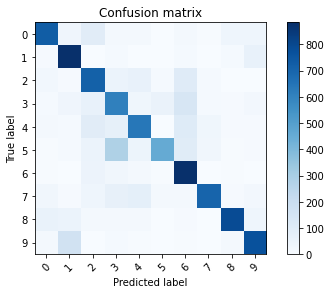

Model Precision: 0.7185
Model Recall: 0.7185
Model F1 Score: 0.7185

Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1000
           1       0.72      0.88      0.79      1000
           2       0.63      0.71      0.67      1000
           3       0.51      0.61      0.56      1000
           4       0.70      0.64      0.67      1000
           5       0.82      0.46      0.59      1000
           6       0.63      0.88      0.74      1000
           7       0.88      0.71      0.78      1000
           8       0.89      0.79      0.83      1000
           9       0.78      0.77      0.78      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000


Transfer Learning: ResNet50 Model


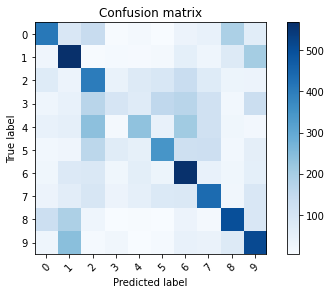

Model Precision: 0.4075
Model Recall: 0.4075
Model F1 Score: 0.4075

Model Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.41      0.45      1000
           1       0.41      0.57      0.47      1000
           2       0.30      0.40      0.34      1000
           3       0.29      0.10      0.15      1000
           4       0.40      0.23      0.30      1000
           5       0.44      0.35      0.39      1000
           6       0.39      0.56      0.46      1000
           7       0.42      0.44      0.43      1000
           8       0.51      0.50      0.50      1000
           9       0.41      0.51      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.39     10000
weighted avg       0.41      0.41      0.39     10000



In [181]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
import os

%matplotlib inline

print('Transfer Learning: VGG16 Model')
print('==============================')
pred = vgg16_model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(new_y_test, axis=1), pred)
plot_confusion_matrix(cm, list(range(10)))
print('Model Precision: ' + str(metrics.precision_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('Model Recall: ' + str(metrics.recall_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('Model F1 Score: ' + str(metrics.f1_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('\nModel Classification Report:\n' + str(metrics.classification_report(np.argmax(new_y_test, axis=1), pred)))

print('\nTransfer Learning: VGG16 Model with Upsampling')
print('==============================================')
pred = vgg16Up_model.predict(x_test)
pred = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), pred)
plot_confusion_matrix(cm, list(range(10)))
print('Model Precision: ' + str(metrics.precision_score(np.argmax(y_test, axis=1), pred, average='micro')))
print('Model Recall: ' + str(metrics.recall_score(np.argmax(y_test, axis=1), pred, average='micro')))
print('Model F1 Score: ' + str(metrics.f1_score(np.argmax(y_test, axis=1), pred, average='micro')))
print('\nModel Classification Report:\n' + str(metrics.classification_report(np.argmax(y_test, axis=1), pred)))

print('\nTransfer Learning: DenseNet201 Model')
print('====================================')
pred = dense_model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(new_y_test, axis=1), pred)
plot_confusion_matrix(cm, list(range(10)))
print('Model Precision: ' + str(metrics.precision_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('Model Recall: ' + str(metrics.recall_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('Model F1 Score: ' + str(metrics.f1_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('\nModel Classification Report:\n' + str(metrics.classification_report(np.argmax(new_y_test, axis=1), pred)))

print('\nTransfer Learning: ResNet50 Model')
print('=================================')
pred = res_model.predict(new_x_test)
pred = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(new_y_test, axis=1), pred)
plot_confusion_matrix(cm, list(range(10)))
print('Model Precision: ' + str(metrics.precision_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('Model Recall: ' + str(metrics.recall_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('Model F1 Score: ' + str(metrics.f1_score(np.argmax(new_y_test, axis=1), pred, average='micro')))
print('\nModel Classification Report:\n' + str(metrics.classification_report(np.argmax(new_y_test, axis=1), pred)))

### 3-5 Images with Predicted and True Labels
Using all of the models produced with transfer learning, I choose 5 random images from my test set and print out the predicted label for each model along with its actual label.

In [217]:
import random

#We will show predicted scores of all transfer learning models
vgg16_pred = vgg16_model.predict(new_x_test)
vgg16_pred = np.argmax(vgg16_pred, axis=1)

vgg16Up_pred = vgg16Up_model.predict(x_test)
vgg16Up_pred = np.argmax(vgg16Up_pred, axis=1)

dense_pred = dense_model.predict(new_x_test)
dense_pred = np.argmax(dense_pred, axis=1)

res_pred = res_model.predict(new_x_test)
res_pred = np.argmax(res_pred, axis=1)

#Get a random 5 images to show
randList = random.sample(range(0, x_test.shape[0]), 5)

VGG16 Predicted: Bird
VGG16 with Upsampling Predicted: Bird
DenseNet201 Predicted: Bird
ResNet50 Predicted: Bird
True: Bird


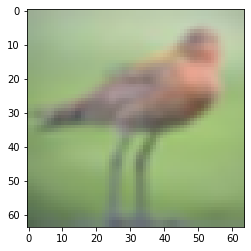

In [218]:
#Show the first image
print('VGG16 Predicted: ' + className[vgg16_pred[randList[0]]])
print('VGG16 with Upsampling Predicted: ' + className[vgg16Up_pred[randList[0]]])
print('DenseNet201 Predicted: ' + className[dense_pred[randList[0]]])
print('ResNet50 Predicted: ' + className[res_pred[randList[0]]])
print('True: ' + className[np.argmax(new_y_test[randList[0]])])
plt.imshow(new_x_test[randList[0]])

VGG16 Predicted: Automobile
VGG16 with Upsampling Predicted: Automobile
DenseNet201 Predicted: Automobile
ResNet50 Predicted: Automobile
True: Automobile


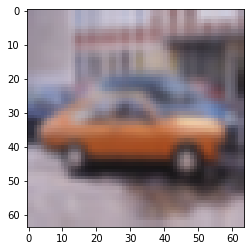

In [219]:
#Show the second image
print('VGG16 Predicted: ' + className[vgg16_pred[randList[1]]])
print('VGG16 with Upsampling Predicted: ' + className[vgg16Up_pred[randList[1]]])
print('DenseNet201 Predicted: ' + className[dense_pred[randList[1]]])
print('ResNet50 Predicted: ' + className[res_pred[randList[1]]])
print('True: ' + className[np.argmax(new_y_test[randList[1]])])
plt.imshow(new_x_test[randList[1]])

VGG16 Predicted: Ship
VGG16 with Upsampling Predicted: Truck
DenseNet201 Predicted: Truck
ResNet50 Predicted: Ship
True: Truck


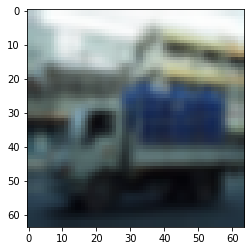

In [220]:
#Show the third image
print('VGG16 Predicted: ' + className[vgg16_pred[randList[2]]])
print('VGG16 with Upsampling Predicted: ' + className[vgg16Up_pred[randList[2]]])
print('DenseNet201 Predicted: ' + className[dense_pred[randList[2]]])
print('ResNet50 Predicted: ' + className[res_pred[randList[2]]])
print('True: ' + className[np.argmax(new_y_test[randList[2]])])
plt.imshow(new_x_test[randList[2]])

VGG16 Predicted: Cat
VGG16 with Upsampling Predicted: Dog
DenseNet201 Predicted: Cat
ResNet50 Predicted: Deer
True: Frog


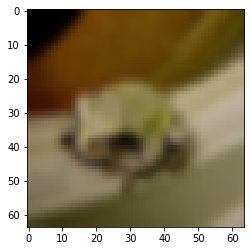

In [221]:
#Show the fourth image
print('VGG16 Predicted: ' + className[vgg16_pred[randList[3]]])
print('VGG16 with Upsampling Predicted: ' + className[vgg16Up_pred[randList[3]]])
print('DenseNet201 Predicted: ' + className[dense_pred[randList[3]]])
print('ResNet50 Predicted: ' + className[res_pred[randList[3]]])
print('True: ' + className[np.argmax(new_y_test[randList[3]])])
plt.imshow(new_x_test[randList[3]])

VGG16 Predicted: Ship
VGG16 with Upsampling Predicted: Ship
DenseNet201 Predicted: Ship
ResNet50 Predicted: Automobile
True: Ship


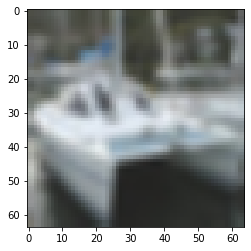

In [222]:
#Show the fifth image
print('VGG16 Predicted: ' + className[vgg16_pred[randList[4]]])
print('VGG16 with Upsampling Predicted: ' + className[vgg16Up_pred[randList[4]]])
print('DenseNet201 Predicted: ' + className[dense_pred[randList[4]]])
print('ResNet50 Predicted: ' + className[res_pred[randList[4]]])
print('True: ' + className[np.argmax(new_y_test[randList[4]])])
plt.imshow(new_x_test[randList[4]])